In [84]:
from functions import *
import random
def vview(structure):

    view(AseAtomsAdaptor().get_atoms(structure))

In [34]:
# importing energies
energies_sp = np.load('./data/crystal/lts/sp/energies_sp.npy',allow_pickle=True)

In [36]:
# getting the energies for the supercell
sc_energies_sp = []
for i in range(len(energies_sp)):
    sc_energies_sp.append(energies_sp[i]*2)

In [66]:
##finding the difference between maximum and minimum energy difference
print(min(sc_energies_sp)-max(sc_energies_sp))

-23.967808924382553


# Pymatgen Structure 

### generating the structure of our new supercell

In [12]:
# New atom
new_atom = 'Li'

# Read the confcount output
cry_output = Crystal_output().read_cry_output('data/crystal/lts/lts_confcount.out')
cry_output.get_config_analysis()

# Read the initial structure (before substitution)
original_structure_gui =  Crystal_gui().read_gui('data/crystal/lts/lts_confcount.gui')
original_structure = cry_gui2pmg(original_structure_gui)

In [13]:
scaling_matrix = np.array([[2., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])
lts_structure = copy.deepcopy(original_structure)
lts_structure.make_supercell(scaling_matrix)
vview(lts_structure)
 

#number of atoms
N_C_g = lts_structure.num_sites
#number of bonds
N_CC_g = N_C_g*1.5

In [15]:
#number of atoms in this supercell
N_C_g

108

### Generating the structures we already Have from ml_sol_sol

In [25]:
### regenerating the structures that we already have
# New atom
new_atom = 'Li'

# Read the confcount output
cry_output = Crystal_output().read_cry_output('data/crystal/lts/lts_confcount.out')
cry_output.get_config_analysis()

# Read the initial structure (before substitution)
original_structure_gui =  Crystal_gui().read_gui('data/crystal/lts/lts_confcount.gui')
original_structure = cry_gui2pmg(original_structure_gui)

structures_lts = []
li_atoms = []
ti_atoms = []
for j,substitutions in enumerate(cry_output.atom_type2):
    new_structure = original_structure.copy()
    for i in substitutions:
        new_structure.replace(i-1,new_atom)
    structures_lts.append(new_structure)
    ti_atoms.append((np.array(cry_output.atom_type1[j])-1).tolist())
    li_atoms.append((np.array(cry_output.atom_type2[j])-1).tolist())

structures = copy.deepcopy(structures_lts)

In [26]:
#turning our old structures into the 2x1x1 supercell
new_structures = []
for i in range(len(structures)):
    now_struct = copy.deepcopy(structures[i])
    now_struct.make_supercell(scaling_matrix)
    new_structures.append(now_struct)

### Generating random structures for the test and validation set

In [93]:
ranset = []
#generating a set of random numbers, in this case we are looking to generating 1000 set of random numbers
for i in range(10000):
    randomlist = random.sample(range(0, 108), 36)
    ranset.append(randomlist)
    if len(x)==str(i):
        print('we now have %s random numbers'%str(len(ranset)))
        break

In [94]:
print(ranset[0])
print(ranset[1])


[49, 85, 45, 5, 87, 11, 41, 12, 2, 62, 48, 39, 100, 104, 34, 64, 82, 40, 69, 77, 13, 27, 22, 18, 31, 67, 54, 33, 88, 20, 43, 103, 86, 36, 94, 19]
[74, 62, 45, 28, 102, 54, 90, 37, 23, 39, 73, 6, 93, 26, 105, 43, 19, 0, 91, 79, 52, 101, 46, 77, 78, 107, 55, 35, 44, 50, 48, 83, 85, 63, 49, 41]


In [95]:
lts_sc_ran = []
for i in range(len(ranset)):
    _struct = lts_structure.copy()
    for j in (ranset[i]):
        _struct.replace(j,'Li')
    
    lts_sc_ran.append(_struct)  

### Ase Structure

In [37]:
ase_structures = []
for i in range(len(structures)):
    ase_struct = AseAtomsAdaptor().get_atoms(structures[i])
    ase_structures.append(ase_struct)

## Generating the CME descriptor

In [40]:
#optimised version of the descriptor
def cm_new(structure):
    dm = structure.distance_matrix
    atomic_numbers = np.array(structure.atomic_numbers)

    diagonal_vals = 0.5 * (atomic_numbers ** 2.4)
    diagonal_matrix = np.diag(diagonal_vals)

    off_diagonal_vals = atomic_numbers[:, np.newaxis] * atomic_numbers / dm
    np.fill_diagonal(off_diagonal_vals, 0)

    cm = diagonal_matrix + off_diagonal_vals

    return np.linalg.eigvals(cm)

In [53]:
#descriptors for the structures in the training set
cm_withE = []
start = datetime.now()
for i in range(len(new_structures)):
    cm_withE.append(cm_new(new_structures[i]))
    now = datetime.now()
    if (i+1)%200 == 0: 
        print("matrices read:", len(cm_withE),", time:", (now - start))
   
print('Number of matrices read: ', len(cm_withE))
print("--- %s time taken ---" % (datetime.now()- start))
cm_withE = np.real(cm_withE)

/var/folders/2h/ms2y6t_d36b5hfhxvdrgy2fm0000gn/T/ipykernel_75572/1764343088.py:9: RuntimeWarning: divide by zero encountered in divide
  off_diagonal_vals = atomic_numbers[:, np.newaxis] * atomic_numbers / dm


matrices read: 200 , time: 0:00:00.416073
matrices read: 400 , time: 0:00:00.771267
matrices read: 600 , time: 0:00:01.120165
matrices read: 800 , time: 0:00:01.465247
matrices read: 1000 , time: 0:00:01.806780
matrices read: 1200 , time: 0:00:02.144656
matrices read: 1400 , time: 0:00:02.482919
matrices read: 1600 , time: 0:00:02.822812
matrices read: 1800 , time: 0:00:03.157414
matrices read: 2000 , time: 0:00:03.497075
matrices read: 2200 , time: 0:00:03.834397
matrices read: 2400 , time: 0:00:04.173134
matrices read: 2600 , time: 0:00:04.505194
matrices read: 2800 , time: 0:00:04.851469
matrices read: 3000 , time: 0:00:05.189779
matrices read: 3200 , time: 0:00:05.524797
matrices read: 3400 , time: 0:00:05.864778
matrices read: 3600 , time: 0:00:06.206517
matrices read: 3800 , time: 0:00:06.551016
matrices read: 4000 , time: 0:00:06.898154
Number of matrices read:  4023
--- 0:00:06.938652 time taken ---


In [102]:
#Generating the descriptor for the test set
cm_noE = []
start = datetime.now()
for i in range(len(lts_sc_ran)):
    cm_noE.append(cm_new(lts_sc_ran[i]))
    now = datetime.now()
    if (i+1)%1000 == 0: 
        print("matrices read:", len(cm_noE),", time:", (now - start))
   
print('Number of matrices read: ', len(cm_noE))
print("--- %s time taken ---" % (datetime.now()- start))
cm_noE = np.real(cm_noE)

/var/folders/2h/ms2y6t_d36b5hfhxvdrgy2fm0000gn/T/ipykernel_75572/1764343088.py:9: RuntimeWarning: divide by zero encountered in divide
  off_diagonal_vals = atomic_numbers[:, np.newaxis] * atomic_numbers / dm


matrices read: 1000 , time: 0:00:01.777404
matrices read: 2000 , time: 0:00:03.519976
matrices read: 3000 , time: 0:00:05.236912
matrices read: 4000 , time: 0:00:06.958223
matrices read: 5000 , time: 0:00:08.794604
matrices read: 6000 , time: 0:00:10.554450
matrices read: 7000 , time: 0:00:12.300728
matrices read: 8000 , time: 0:00:14.007053
matrices read: 9000 , time: 0:00:15.729462
matrices read: 10000 , time: 0:00:17.435874
Number of matrices read:  10000
--- 0:00:17.436601 time taken ---


### Generating the train test and Validation set

In [103]:
# preparing our data set
Xtrain = cm_withE
ytrain = sc_energies_sp
Xtest = cm_noE
ytest = []
vals = int(len(Xtrain)*0.20)
#reserving the 100 structures from the training set for validation
from numpy import random
Xval = Xtrain[-vals:]
yval = ytrain[-vals:]
Xtrain = Xtrain[:-vals]
ytrain = ytrain[:-vals]

print("Number of training examples after validation taken: {}".format(len(Xtrain)))
print("Number of validation examples: {}".format(len(Xval)))
print("Number of test examples:     {}".format(len(Xtest)))

#normalising the data that we are using:
scaler = StandardScaler()
scaler.fit(Xtrain)
Xtrain = scaler.transform(Xtrain)
Xtest = scaler.transform(Xtest)
Xval = scaler.transform(Xval)

print('normalisation completed')

Number of training examples after validation taken: 3219
Number of validation examples: 804
Number of test examples:     10000
normalisation completed


## Training the data

In [58]:
from scipy.stats import uniform, randint
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
import xgboost as xgb
model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

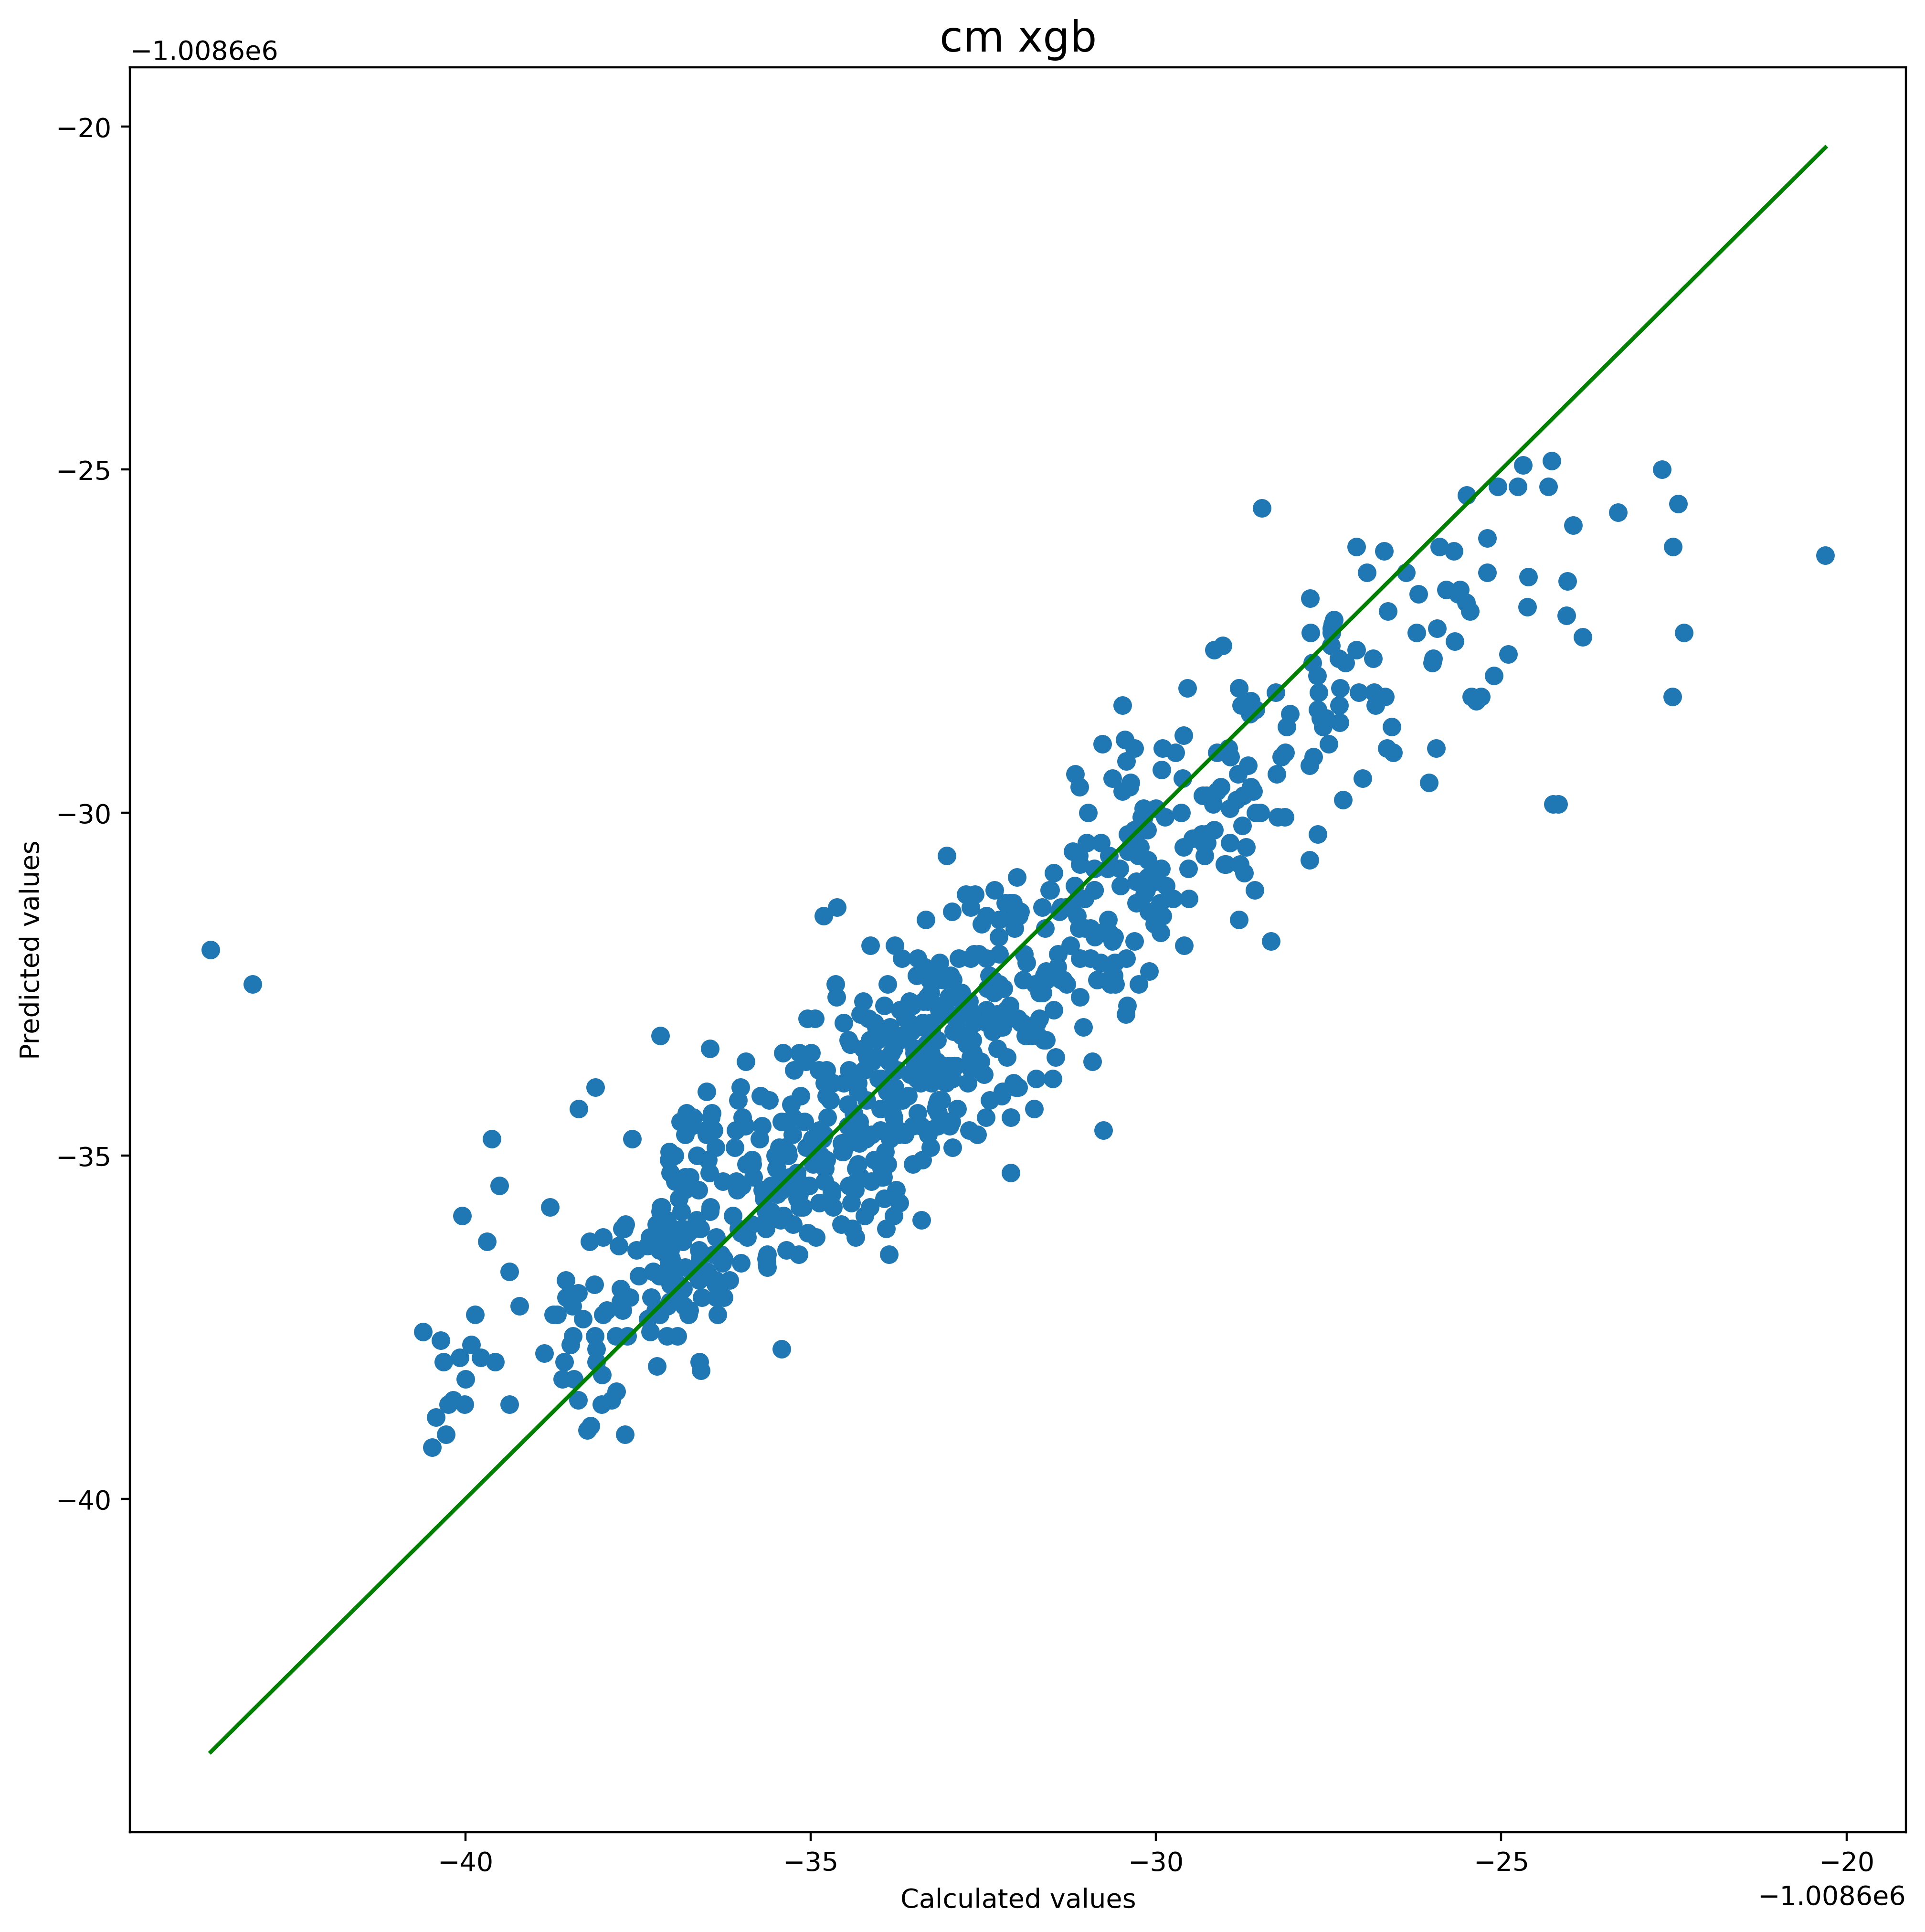

,r^2 value,mean absolute error,maximum error
0,0.841291,1054.001936,11686.963768


In [61]:
#finding validation error
model.fit(Xtrain, ytrain)
ypred = model.predict(Xval)
errorgraph(yval,ypred, 'cm', 'xgb')

In [71]:
#percentage error for validation set
print(1054/(23.967808924382553*1000)*100,'%')

4.397565097941687 %


In [104]:
## finding the prediction for the test energies
ypred = model.predict(Xtest)
len(ypred)

10000

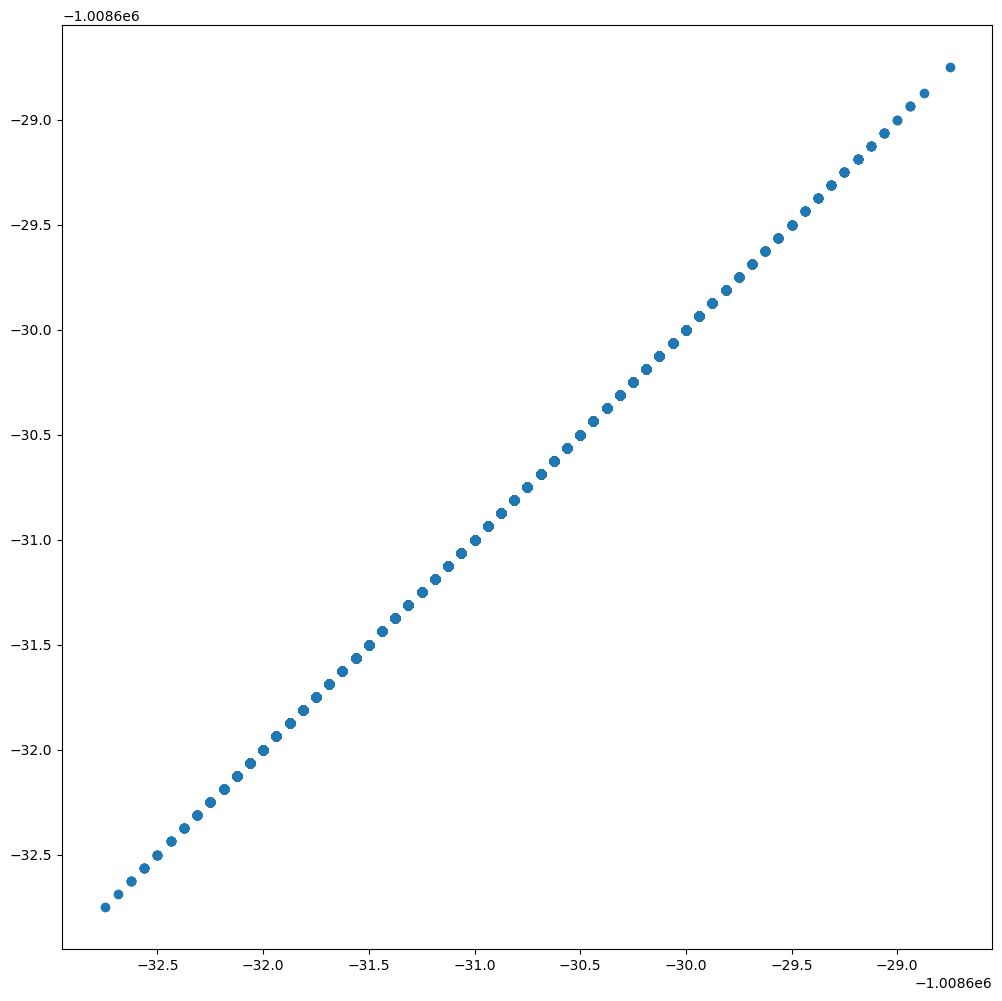

In [108]:
#the predicted energies for the 10,000 random structures were produced in 1 second
plt.scatter(ypred,ypred)